In [1]:
import torch


from torch.utils.data import Dataset

In [2]:
torch.cuda.is_available()

True

In [3]:
import os
class seismoDataset(Dataset):
    def __init__(self, path_to_data, device, start = 0, fin = 1600):
        self.path_to_data =  path_to_data
        self.start = start
        self.fin = fin
        self.device = device
    def __len__(self):
        return self.fin - self.start

    def __getitem__(self, idx0):
        idx = self.start+idx0
        sample_path = os.path.join(self.path_to_data, 'ore_{idx}'.format(idx = idx))
        src = torch.load(sample_path+'/src.pt', weights_only=True)
        trg = torch.load(sample_path+'/trg.pt', weights_only=True)

        return src, trg
    def split(self, split_ratio = [0.9 , 0.1]):
        assert sum(split_ratio) == 1
        idxes = [0]+[int(i*(self.fin - self.start)) for i in torch.cumsum(torch.tensor(split_ratio), dim = 0)]
        return [seismoDataset(self.path_to_data, self.device, start = idxes[i], fin = idxes[i+1]) for i in range(len(split_ratio))]

In [4]:
from torch.utils.data import DataLoader
device =torch.device('cuda')


training_data = seismoDataset('/home/mamber/u_net/torch_dataset_og', device)


train_data, test_data = training_data.split(split_ratio =[0.95, 0.05])
from unet import unet_model
import train


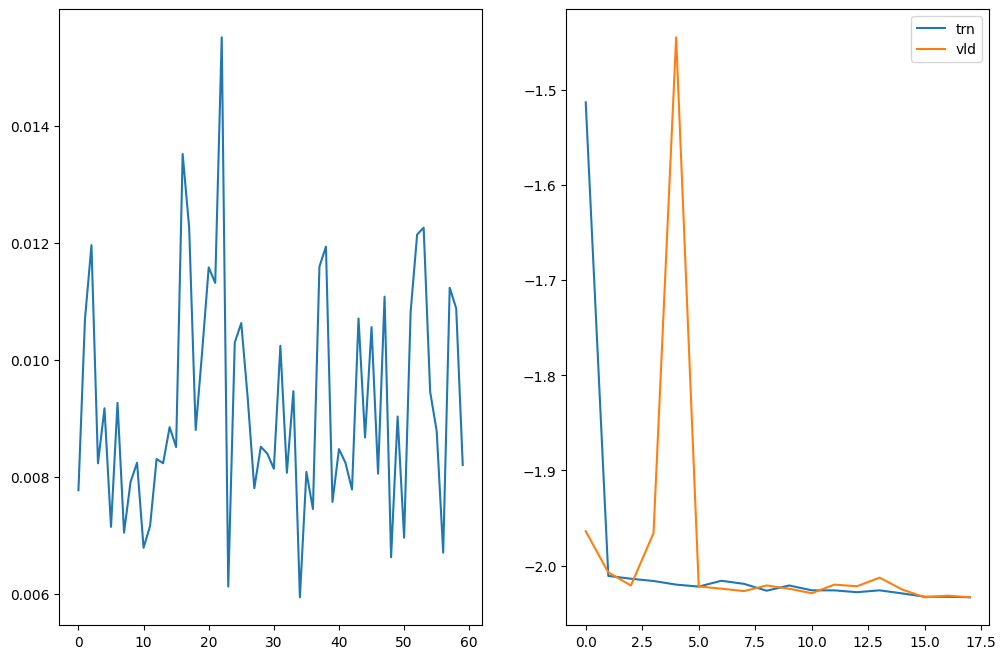

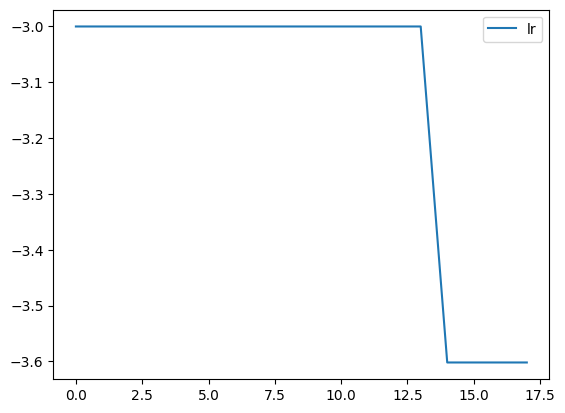

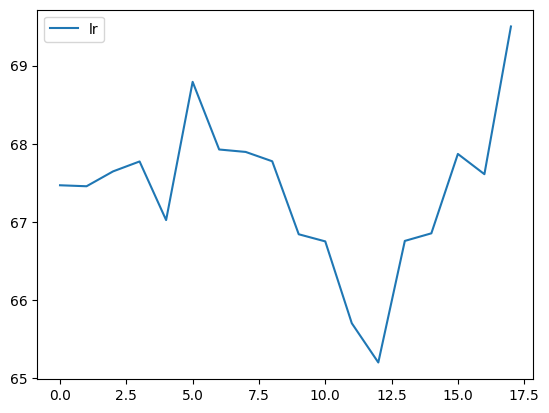

KeyboardInterrupt: 

In [6]:
model = unet_model.UNet(16, 1).to(device)
#PATH = '/home/mamber/u_net/master/unt_mdl15.pt'
#model.load_state_dict(torch.load(PATH))
train.train_model(model, device, train_data, attempt = 115, batch_size = 8, learning_rate=1e-3)

In [ ]:
model = unet_model.UNet(16, 1).to(device)
train.train_model(model, device, train_data, attempt = 329) #change variable 'attempt' every attempt

In [7]:
model = unet_model.UNet(1, 16).to(device)
PATH = '/home/mamber/u_net/master/unt_mdl6.pt'
model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

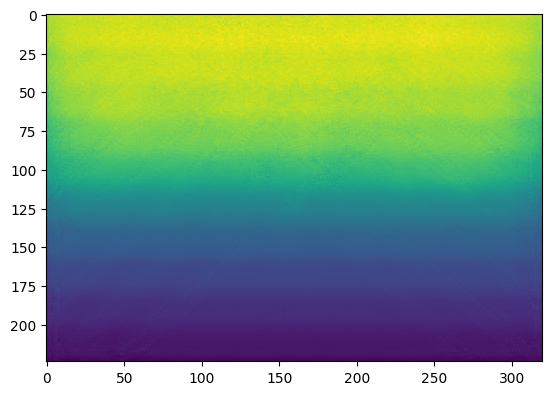

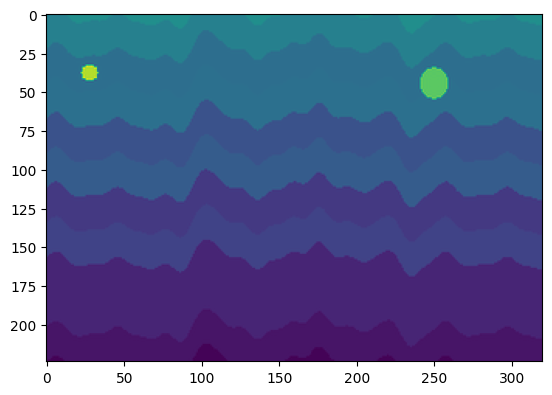

In [8]:
import matplotlib.pyplot as plt

src, trg = test_data[15]
show = model(src.to(device)[None, :, :, :]).detach().cpu()
plt.imshow(show[0, 0, :, :])
plt.show()
plt.imshow(trg.cpu())

(224, 320)
(224, 30) (30,) (30, 320)


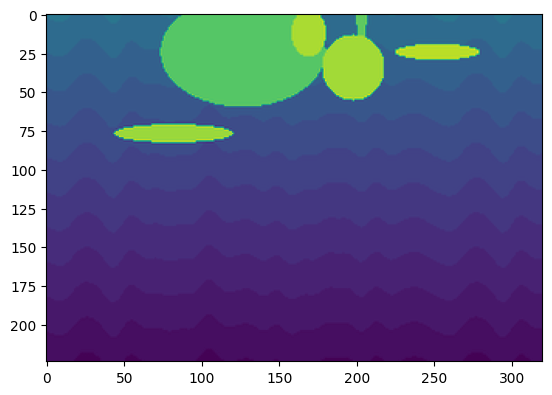

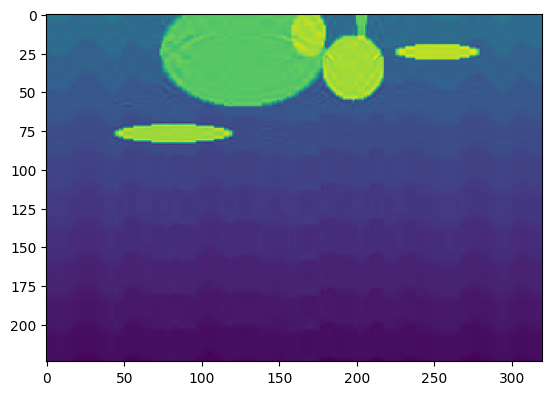

In [24]:
import numpy as np
import matplotlib.pyplot as plt
src, trg = training_data[20]
src = np.array(src.detach().cpu())[4, :, :]
trg = np.array(trg.detach().cpu())
print(src.shape)
u, s, vh = np.linalg.svd(trg, full_matrices = False)
u = u[:, :30] 
s = s[:30] 
vh = vh[:30, :]
print(u.shape, s.shape, vh.shape)
plt.imshow(trg)
plt.show()
plt.imshow(u[:, :20] @ np.diag(s[:20]) @ vh[:20, :])

u.tofile('/home/mamber/u_net/master/u.bin')
s.tofile('/home/mamber/u_net/master/s.bin')
vh.tofile('/home/mamber/u_net/master/vh.bin')


In [28]:
os.mkdir('/home/mamber/u_net/master/compressed_dataset2')
path = '/home/mamber/u_net/master/compressed_dataset2'
for i in range(1600):
    if i%100==0:
        print(i)
    src, trg = training_data[i]
    src = np.array(src.detach().cpu()).sum(axis=0)
    
    os.mkdir(path+'/sample_{i}'.format(i=i))

    us, ss, vhs = np.linalg.svd(src, full_matrices = False)
    us = us[:, :30] 
    ss = ss[:30] 
    vhs = vhs[:30, :]

    os.mkdir(path+'/sample_{i}/src'.format(i=i))

    
    us.tofile(path+'/sample_{i}/src/u.bin'.format(i=i))
    ss.tofile(path+'/sample_{i}/src/s.bin'.format(i=i))
    vhs.tofile(path+'/sample_{i}/src/vh.bin'.format(i=i))

    ut, st, vht = np.linalg.svd(trg, full_matrices = False)
    ut = ut[:, :20] 
    st = st[:20] 
    vht = vht[:20, :]

    os.mkdir(path+'/sample_{i}/trg'.format(i=i))

    
    ut.tofile(path+'/sample_{i}/trg/u.bin'.format(i=i))
    st.tofile(path+'/sample_{i}/trg/s.bin'.format(i=i))
    vht.tofile(path+'/sample_{i}/trg/vh.bin'.format(i=i))

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500


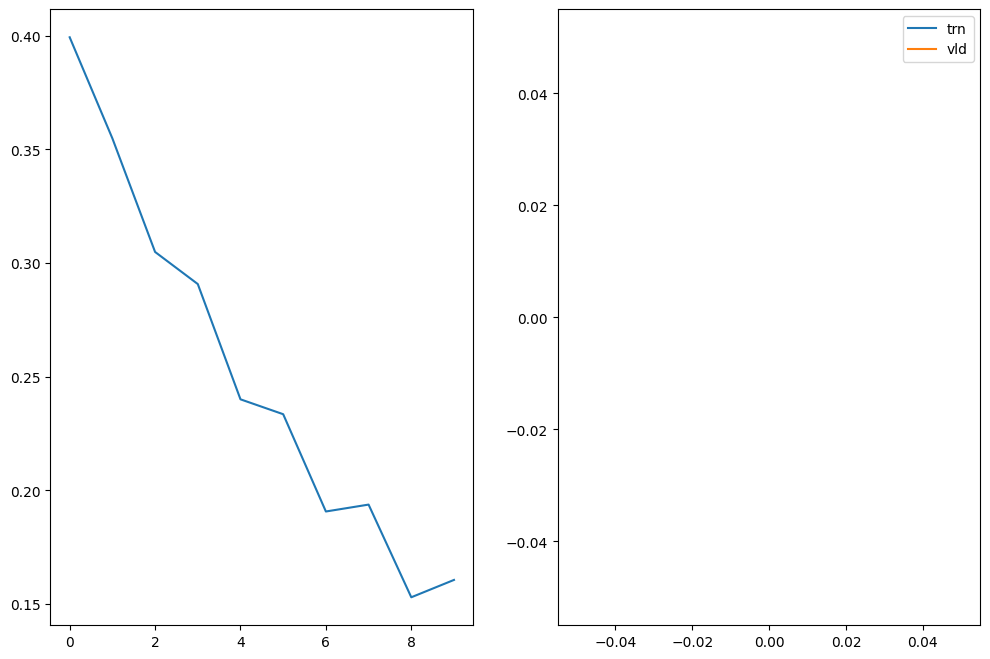

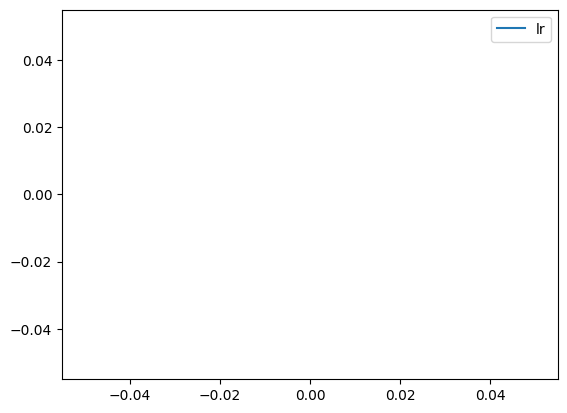

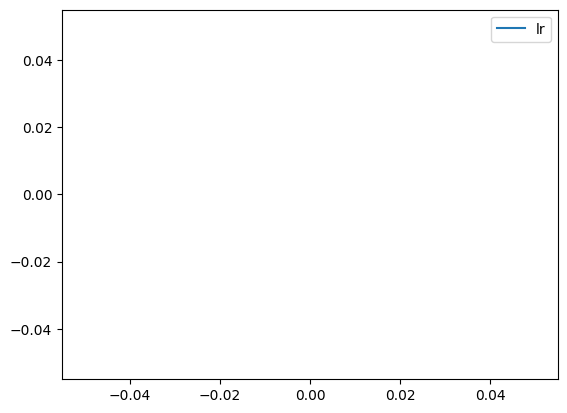

In [ ]:
model = unet_model.UNet(16, 1).to(device)
train.train_model(model, device, train_data, attempt = 329) #change variable 'attempt' every attempt

In [7]:
import evaluate
from unet import unet_model
model1 = unet_model.UNet(16, 1).to(device)
PATH = '/home/mamber/u_net/master/unt_mdl6.pt'
model1.load_state_dict(torch.load(PATH))
print(evaluate.evaluation(model1, device, test_data))

RuntimeError: Error(s) in loading state_dict for UNet:
	size mismatch for inc.double_conv.0.weight: copying a param with shape torch.Size([64, 1, 3, 3]) from checkpoint, the shape in current model is torch.Size([64, 16, 3, 3]).
	size mismatch for outc.conv.weight: copying a param with shape torch.Size([16, 64, 1, 1]) from checkpoint, the shape in current model is torch.Size([1, 64, 1, 1]).
	size mismatch for outc.conv.bias: copying a param with shape torch.Size([16]) from checkpoint, the shape in current model is torch.Size([1]).

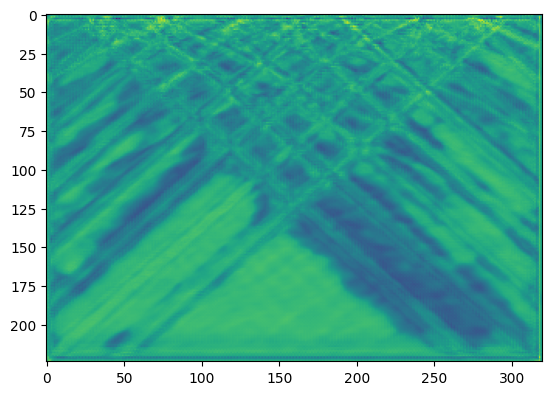

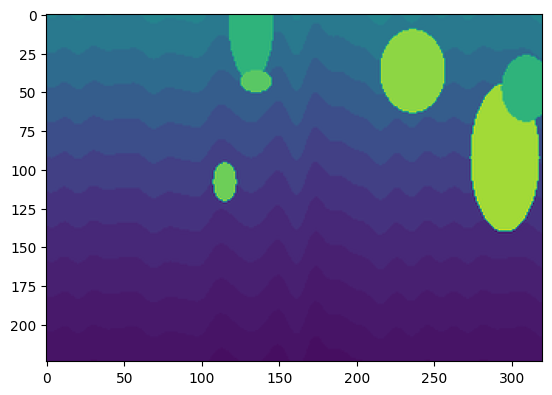

In [8]:
import matplotlib.pyplot as plt
src, trg = test_data[20]
src = src.to(device)
trg = trg.to(device)

plt.imshow(model1(src[None, :,:, :]).detach().cpu()[0, 0, :, :])
plt.show()
plt.imshow(trg.detach().cpu()[:, :])
plt.show()

In [11]:
from unet import unet_model
model = unet_model.UNet(16, 1).to(device)
import train
train.train_model(model, device, train_data, attempt=328, epochs=50, learning_rate = 0.0001, weight_decay = 1e-4, batch_size = 4)

RuntimeError: Given groups=1, weight of size [64, 16, 3, 3], expected input[4, 1, 224, 320] to have 16 channels, but got 1 channels instead

In [18]:
import evaluate
from unet import unet_model
model1 = unet_model.UNet(1, 16).to(device)
PATH = '/home/mamber/u_net/master/unt_mdl327.pt'
model1.load_state_dict(torch.load(PATH))
#print(evaluate.evaluation(model1, device, test_data))

<All keys matched successfully>

torch.Size([224, 320])
torch.Size([16, 224, 320])


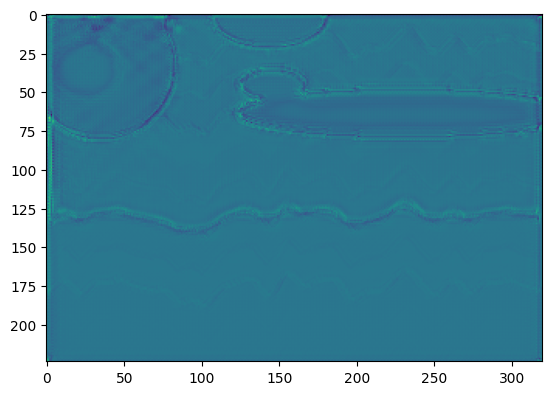

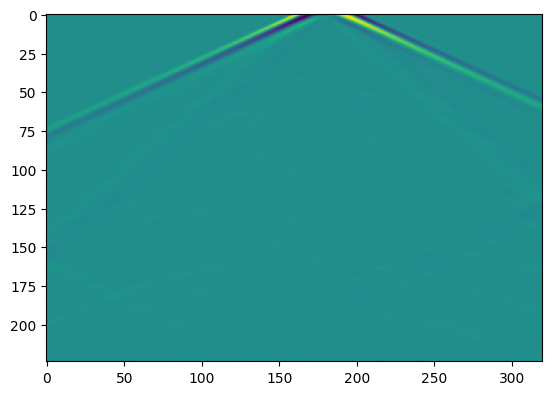

In [19]:
import matplotlib.pyplot as plt
trg, src = test_data[8]
src = src.to(device)
trg = trg.to(device)
print(src.size())
print(trg.size())
I =4
plt.imshow(model1(src[None, None, :, :]).detach().cpu()[0, I, :, :])
plt.show()
plt.imshow(trg.detach().cpu()[ I, :, :])
plt.show()